In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import Normalizer

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [3]:
X_train = np.array(df_train.iloc[:, :-1])
y_train = np.array(df_train.iloc[:, -1])
X_test = np.array(df_test.iloc[:, :-1])
y_test = np.array(df_test.iloc[:, -1])

normaliser = Normalizer()
X_train = normaliser.fit_transform(X=X_train)
X_test = normaliser.transform(X=X_test)

In [4]:
X_train.shape

(384, 8)

In [5]:
y_train.shape

(384,)

### ORIGINAL

In [6]:
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    # posterior mean Mu and cov SIGMA with basis matrix PHI
    # and width hyperparam alph and s2
    # where alph = lam/s2

    SIGMA = np.linalg.inv(alph*np.eye(PHI.shape[0]) + (1/s2)*PHI.T@PHI)
    Mu = (1/s2)*SIGMA@PHI.T@y
    
    return Mu, SIGMA

In [7]:
def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    Mu, SIGMA = compute_posterior(PHI, y, alph, s2)
    N = PHI.shape[0]
    M = PHI.shape[1]
#     lgp = stats.multivariate_normal.logpdf()
    E_m_N = 1/(s2*2) * np.linalg.norm(y-PHI@Mu)**2 + alph/2*Mu.T@Mu
    lgp = 0.5*M*np.log(alph) + 0.5*N*np.log(1/s2) - E_m_N - 0.5*np.log(np.linalg.det(np.linalg.inv(SIGMA))) - 0.5*N*np.log(2*np.pi)
    return lgp



### MODIFIED

In [8]:
def compute_posterior(X, y, sigma_w_2, sigma_n_2):
    SIGMA = np.linalg.inv((1/sigma_w_2)*np.eye(X.shape[1]) + (1/sigma_n_2)*X.T@X)
    Mu = (1/sigma_n_2)*SIGMA@X.T@y
    
#     N = X.shape[0]
#     shared = np.linalg.inv(X.T@X + sigma_n_2*sigma_w_2*np.eye(N))
#     Mu = shared@X.T@y
#     SIGMA = sigma_n_2*shared
    return Mu, SIGMA

def compute_log_marginal(X, y, sigma_w_2, sigma_n_2):

    Mu, SIGMA = compute_posterior(X, y, sigma_w_2, sigma_n_2)
    N = X.shape[0]
    M = X.shape[1]
#     lgp = stats.multivariate_normal.logpdf()
    E_m_N = 1/(sigma_n_2*2) * np.linalg.norm(y-X@Mu)**2 + (1/sigma_w_2)/2*Mu.T@Mu
    lgp = 0.5*M*np.log((1/sigma_w_2)) + 0.5*N*np.log(1/sigma_n_2) - E_m_N - 0.5*np.log(np.linalg.det(np.linalg.inv(SIGMA))) - 0.5*N*np.log(2*np.pi)
    return lgp

### NEW VERSION

In [9]:
def compute_log_marginal(X, y, sigma_n_2, sigma_w_2):
    N = X.shape[0]
    shared = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
    first = (N/2)*np.log(2*np.pi)
    second = 0.5*np.log(np.linalg.det(shared))
    third = -0.5*y.T@np.linalg.inv(shared)@y
    return first + second + third

In [17]:
### USING ZERO-MEAN GAUSSIAN CONCEPT

def compute_log_marginal(X, y, sigma_n_2, sigma_w_2):
    N = X.shape[0]
    cov = sigma_n_2*np.eye(N) + sigma_w_2*X@X.T
    return stats.multivariate_normal.logpdf(X, mean=None, cov=cov, allow_singular=True)
    
compute_log_marginal(X_train, y_train, 0.01, 0.01)

ValueError: operands could not be broadcast together with shapes (384,8) (384,) 

### Hyperparameter grid

In [10]:
sigma_n_2_power_grid = np.linspace(-5, 5, 100)
sigma_w_2_power_grid = np.linspace(-1, 1, 100)

log_prob_list = []

for power_sigma_n_2 in sigma_n_2_power_grid:
    for power_sigma_w_2 in sigma_w_2_power_grid:
        log_prob = compute_log_marginal(X_train, y_train, 10**power_sigma_n_2, 10**power_sigma_w_2)
        log_prob_list.append(log_prob)

<ipython-input-9-ffadec29a926>:5: RuntimeWarning: divide by zero encountered in log
  second = 0.5*np.log(np.linalg.det(shared))
/Users/jihoon/miniforge3/envs/atf2/lib/python3.8/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [11]:
# prob_list to 2d shape
log_prob_list = np.array(log_prob_list).reshape(100, 100)

In [12]:
log_prob_list[50]

array([-17396.78470472, -17201.66097173, -17008.86885049, -16818.18407026,
       -16629.39352825, -16442.29546098, -16256.6996096 , -16072.42737736,
       -15889.31197765, -15707.19857014, -15525.94438294, -15345.41881783,
       -15165.50353592, -14986.09252064, -14807.09211508, -14628.42103043,
       -14450.01032254, -14271.80333352, -14093.75559546, -13915.83469378,
       -13738.0200876 , -13560.30288528, -13382.68557342, -13205.18169821,
       -13027.81549845, -12850.6214902 , -12673.6440036 , -12496.93667299,
       -12320.56188214, -12144.59016708, -11969.09957949, -11794.17501442,
       -11619.90750661, -11446.39350006, -11273.73409612, -11102.03428579,
       -10931.40217189, -10761.94818747, -10593.78431648, -10427.02332297,
       -10261.77799504, -10098.16040935,  -9936.28122207,  -9776.2489914 ,
        -9618.16953668,  -9462.14533849,  -9308.27498346,  -9156.65265708,
        -9007.36768715,  -8860.50413971,  -8716.14046872,  -8574.34922028,
        -8435.19679117,  

In [13]:
log_prob_list.max()

inf

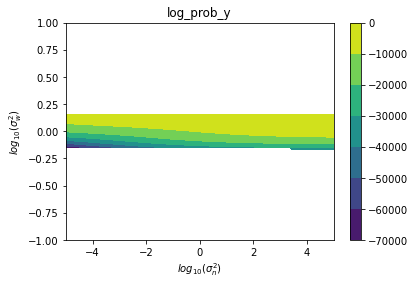

In [14]:
plt.contourf(sigma_n_2_power_grid, sigma_w_2_power_grid, log_prob_list) #[X, Y], Z
plt.title("log_prob_y")
plt.xlabel(r"$log_{10} (\sigma_n^2)$")
plt.ylabel(r"$log_{10} (\sigma_w^2)$")
plt.colorbar()
plt.show()

# plt.contourf(alph_power_grid, r_power_grid, prob_y) #[X, Y], Z
# plt.title("prob_y")
# plt.xlabel(r"$log_{10} (\alpha)$")
# plt.ylabel(r"$log_{10} (r)$")
# plt.colorbar()
# plt.show()

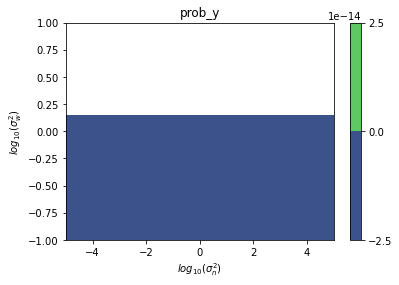

In [15]:
prob_list = np.exp(log_prob_list)

plt.contourf(sigma_n_2_power_grid, sigma_w_2_power_grid, prob_list) #[X, Y], Z
plt.title("prob_y")
plt.xlabel(r"$log_{10} (\sigma_n^2)$")
plt.ylabel(r"$log_{10} (\sigma_w^2)$")
plt.colorbar()
plt.show()



In [16]:
prob_list

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])